# **Python脑电数据处理中文手册 v0.1**  
# **——单被试数据预处理篇**  
  
编者：  
- 路子童 - 俄亥俄州立大学  
- 李婉如 - 北京大学  
- 聂露 - 中山大学
- 赵匡是 - 心仪脑

如对本教程有任务疑问或建议，欢迎通过以下方式联系：  
1 在公众号”路同学“后台留言  
2 邮件联系路子童，邮箱为zitonglu1996@gmail.com

#  前言

**几乎所有脑电初学者都是从EEGLAB开始接触脑电预处理过程的  
EEGLAB浅显直观的GUI界面再或是基于MATLAB的代码操作影响了一代脑电人  
然而，随着简洁、易上手的Python语言的快速发展  
其丰富的社区资源也扩张到了认知神经科学领域  
MNE-Python、Nilearn、Nibabel等等相关工具包层出不穷    
遗憾的是，它们未能在国内迅速地普及，相对门庭冷淡  
为了弥补这一空白，并为更高阶的脑电数据操作架起桥梁（例如之后使用NeuroRA等Python工具包）  
我们尝试完成一个中文版的Python脑电处理教程  
目前，这个预处理手册是我们第一阶段的成果  
要感谢贾会宾老师的《EEGLAB中文手册》以及Steven Luck的《事件相关电位基础》给我们的参考  
要感谢Memory and Emotion Lab的成员和MNE-Python交流群里各位的支持与建议  
希望这个预处理手册是国内Python脑电数据处理中文手册的第一步，但也不仅仅是第一步！**  

***

由于大多数小伙伴熟悉的脑电数据处理工具包为基于MATLAB的EEGLAB  
这里使用的数据为MATLAB经典脑电数据处理工具包EEGLAB中的经典数据"eeglab_data.set"

在此单被试分析篇中，按照脑电预处理流程，分为以下6个步骤：  
- **Step 1: 读取数据**  
- **Step 2: 滤波**  
- **Step 3: 去伪迹**  
- **Step 4: 重参考**  
- **Step 5: 分段**  
- **Step 6: 叠加平均**  
- **Step 7: 时频分析**
- **Step 8: 提取数据**

需要用到的Python工具包包括：
**[NumPy](https://numpy.org/)**及**[MNE-Python](https://mne.tools/stable/index.html)**  
安装方法即为在命令行窗口中输入以下代码：
> pip install numpy  
> pip install mne

# Step 1 读取数据

### 导入原始数据

In [1]:
import numpy as np
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet

# 数据地址（需要改成你自己的数据地址，在EEGLAB文件夹的sample_data文件夹下）
data_path = "/Users/zitonglu/Desktop/EEG/eeglab14_1_2b/sample_data/eeglab_data.set"

# MNE-Python中对多种格式的脑电数据都进行了支持：
# *** 如数据后缀为.set (来自EEGLAB的数据)
#     使用mne.io.read_raw_eeglab()
# *** 如数据后缀为.vhdr (BrainVision系统)
#     使用mne.io.read_raw_brainvision()
# *** 如数据后缀为.edf
#     使用mne.io.read_raw_edf()
# *** 如数据后缀为.bdf (BioSemi放大器)
#     使用mne.io.read_raw_bdf()
# *** 如数据后缀为.gdf
#     使用mne.io.read_raw_gdf()
# *** 如数据后缀为.cnt (Neuroscan系统)
#     使用mne.io.read_raw_cnt()
# *** 如数据后缀为.egi或.mff
#     使用mne.io.read_raw_egi()
# *** 如数据后缀为.data
#     使用mne.io.read_raw_nicolet()
# *** 如数据后缀为.nxe (Nexstim eXimia系统)
#     使用mne.io.read_raw_eximia()
# *** 如数据后缀为.lay或.dat (Persyst系统)
#     使用mne.io.read_raw_persyst()
# *** 如数据后缀为.eeg (Nihon Kohden系统)
#     使用mne.io.read_raw_nihon()

# 读取数据
raw = mne.io.read_raw_eeglab(data_path, preload=True)

Reading /Users/zitonglu/Desktop/EEG/eeglab14_1_2b/sample_data/eeglab_data.fdt
Reading 0 ... 30503  =      0.000 ...   238.305 secs...


### 查看原始数据信息

In [2]:
print(raw)
print(raw.info)

<RawEEGLAB | eeglab_data.fdt, 32 x 30504 (238.3 s), ~7.5 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: EEG 000, EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


可以看到该脑电数据为32个导联，30504个时间点（采样率为128Hz，对应238.3s的长度）  
由于读取数据时preload设为True，数据读入内存中，数据大小约为7.5MB  
导联名其次为EEG 000, EEG 001, EEG 002, EEG 003等等  
未进行参考  
高通滤波0.0Hz，低通滤波64.0Hz  

### 电极定位

这里由于导联名称不是标准的名称  
如果碰到类似问题，需要手动导入脑电数据的电极位置信息  
在这个例子中，即需要把数据集相关的.locs文件中的信息传入这里读取的脑电数据中

In [3]:
# locs文件地址
locs_info_path = "/Users/zitonglu/Desktop/EEG/eeglab14_1_2b/sample_data/eeglab_chan32.locs"
# 读取电极位置信息
montage = mne.channels.read_custom_montage(locs_info_path)
# 读取正确的导联名称
new_chan_names = np.loadtxt(locs_info_path, dtype=str, usecols=3)
# 读取旧的导联名称
old_chan_names = raw.info["ch_names"]
# 创建字典，匹配新旧导联名称
chan_names_dict = {old_chan_names[i]:new_chan_names[i] for i in range(32)}
# 更新数据中的导联名称
raw.rename_channels(chan_names_dict)
# 传入数据的电极位置信息
raw.set_montage(montage)

<RawEEGLAB | eeglab_data.fdt, 32 x 30504 (238.3 s), ~7.5 MB, data loaded>

当你的脑电电极位点为一些特定系统时，可以直接用mne.channels.make_standard_montage函数生成
以标准的国际10-20系统为例，对应代码即可改为：  
> montage = mne.channels.make_standard_montage("standard_1020")   

MNE中现成的其他定位系统的montage可以通过以下网址查询：  
[https://mne.tools/stable/generated/mne.channels.make_standard_montage.html#mne.channels.make_standard_montage](https://mne.tools/stable/generated/mne.channels.make_standard_montage.html#mne.channels.make_standard_montage)

#### 设定导联类型

In [4]:
# 设定导联类型为eeg和eog
chan_types_dict = {new_chan_names[i]:"eeg" for i in range(32)}
chan_types_dict = {"EOG1":"eog", "EOG2":"eog"}
raw.set_channel_types(chan_types_dict)

<RawEEGLAB | eeglab_data.fdt, 32 x 30504 (238.3 s), ~7.5 MB, data loaded>

#### 查看修改后的数据信息

In [5]:
# 打印修改后的数据相关信息
print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: FPz, EOG1, F3, Fz, F4, EOG2, FC5, FC1, FC2, FC6, T7, C3, C4, Cz, ...
 chs: 30 EEG, 2 EOG
 custom_ref_applied: False
 dig: 32 items (32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


### 可视化原始数据

#### 绘制原始数据波形图

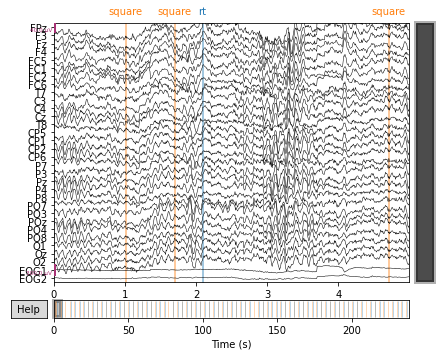

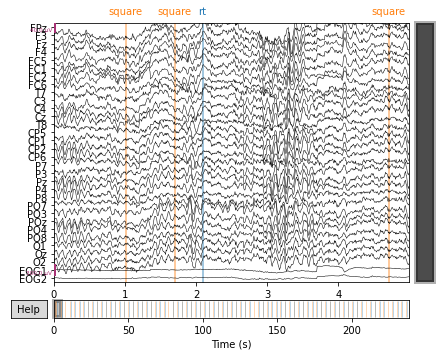

In [7]:
raw.plot(duration=5, n_channels=32, clipping=None)

#### 绘制原始数据功率谱图

Effective window size : 16.000 (s)


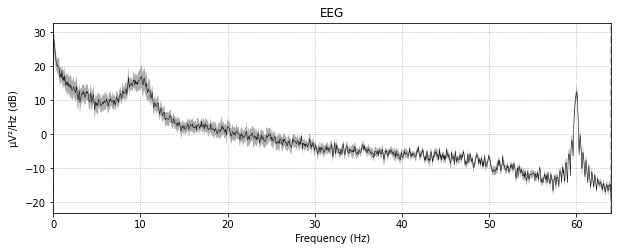

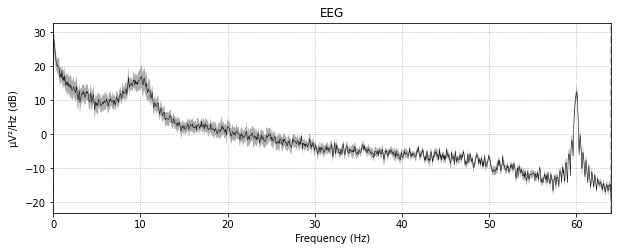

In [8]:
raw.plot_psd(average=True)

#### 绘制电极拓扑图

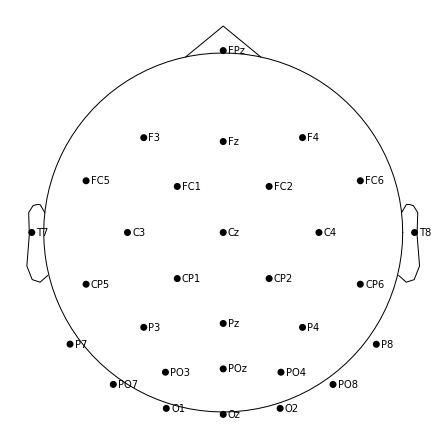

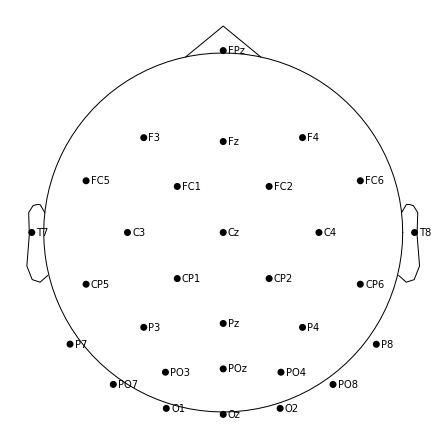

In [9]:
raw.plot_sensors(ch_type='eeg', show_names=True)

#### 绘制原始数据拓扑图

Effective window size : 16.000 (s)


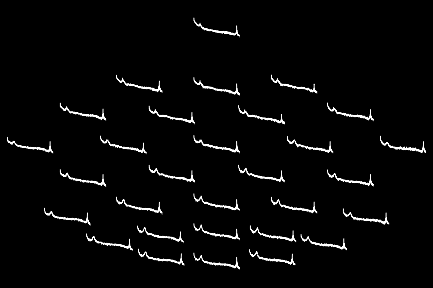

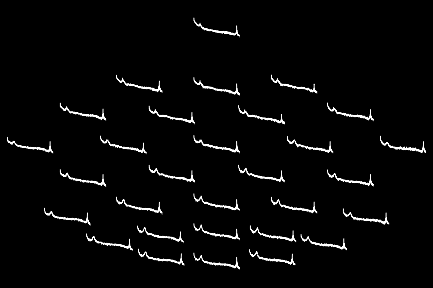

In [10]:
raw.plot_psd_topo()

# Step 2 滤波

### 陷波滤波

通过Step1中的功率谱图可以看到60Hz处可能存在环境噪音  
这里首先使用陷波滤波器去掉工频  
**注意**：在中国大陆及香港澳门地区（除台湾省以外）采集的数据一般工频会出现在50Hz处  
此例比较例外，切记通过功率谱图判断

In [11]:
raw = raw.notch_filter(freqs=(60))

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)



绘制功率谱图

Effective window size : 16.000 (s)


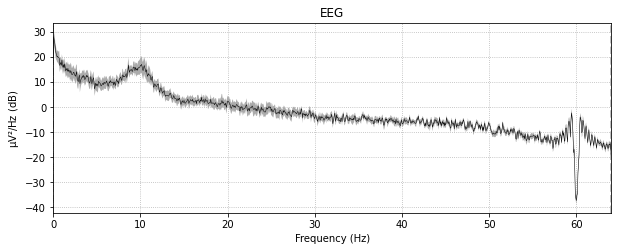

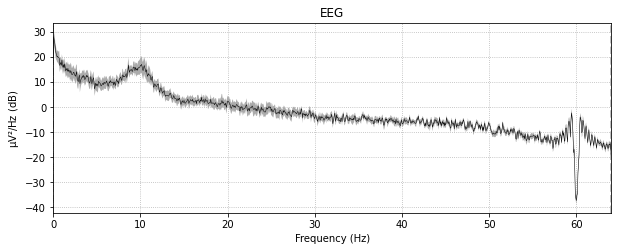

In [12]:
raw.plot_psd(average=True)

### 高低通滤波

预处理步骤中，通常需要对数据进行高通滤波操作  
此处采用最常规的滤波操作，进行30Hz的低通滤波及0.1Hz的高通滤波  
高通滤波为了消除电压漂移，低通滤波为了消除高频噪音

In [13]:
raw = raw.filter(l_freq=0.1, h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4225 samples (33.008 sec)



MNE中默认使用FIR滤波方法，若想使用IIR滤波方法，可通过修改参数method参数实现  
默认method='fir'，使用IIR则修改为'iir'  
对应代码即为：
> raw = raw.filter(l_freq=30, h_freq=0.1, method='iir')

绘制功率谱图

Effective window size : 16.000 (s)


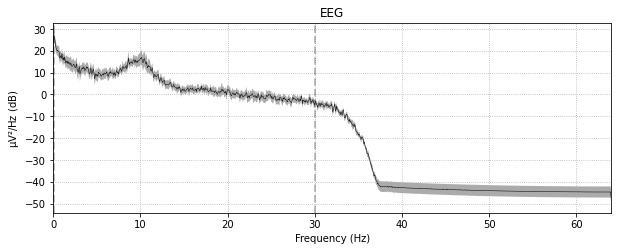

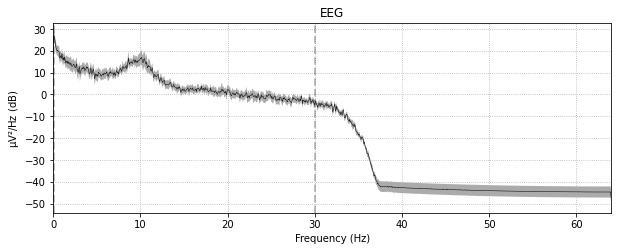

In [14]:
raw.plot_psd(average=True)

# Step 3 去伪迹

### 去坏段

MNE中可以通过打开交互式数据地形图界面，手动进行坏段标记

> fig = raw.plot(duration=5, n_channels=32, clipping=None)  
> fig.canvas.key_press_event('a')

按a就可以打开这个GUI小窗口，add new label可以添加一个用于标记坏段的marker  
在MNE中，并不会将坏段直接删掉，而是进行了数据标记  
在之后的数据处理中，  
将进行数据处理的函数中的参数reject_by_annotation设为True即可在处理过程中自动排除标记的片段  
如果遇到GUI窗口无法弹出，需在脚本开头添加如下代码：
> import matplotlib  
> matplotlib.use('TkAgg')

**注意**：不推荐在Jupyter notebook中打开，容易卡死

### 去坏道

MNE中坏的导联也不是直接删掉，也是通过对坏道进行'bads'标记  
在这个例子中，假定导联'FC5'为坏道，则把'FC5'进行坏道标记

In [15]:
# 坏道标记
raw.info['bads'].append('FC5')
# 打印出当前的坏道
print(raw.info['bads'])

['FC5']


当然，也可以添加多个坏道  
如若'FC5'和'C3'都为坏道，则通过下述代码标记：  
> raw.info['bads'].extend(['FC5', 'C3']) 

### 坏道插值重建

MNE的坏道重建即是对标记为'bads'的导联进行了信号重建

In [16]:
raw = raw.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors


进行信号重建后会默认把坏掉的'bads'标记去掉  
如果不想去掉对原坏道的标记，则将reset_bads参数设为False即可，  
对应代码如下：  
> raw = raw.interpolate_bads(reset_bads=False)

### 独立成分分析（ICA）

#### 运行ICA

MNE中进行ICA的编程思路是首先构建一个ICA对象（可以理解成造一个ICA分析器）  
然后用这个ICA分析器对脑电数据进行分析（通过ICA对象的一系列方法）  
由于ICA对低频分离效果不好  
这里对高通1Hz的数据进行ICA及相关成分剔除，再应用到高通0.1Hz的数据上

In [17]:
ica = ICA(max_iter='auto')
raw_for_ica = raw.copy().filter(l_freq=1, h_freq=None)
ica.fit(raw_for_ica)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 sec)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 29 components
Fitting ICA took 2.3s.


<ICA | raw data decomposition, fit (fastica): 30504 samples, 29 components, channels used: "eeg">

这里没有设定n_components，即ICA的成分数让MNE的ICA分析器自动去选择  
类似EEGLAB，如果希望ICA的成分数为固定个数，可以自定义设置（n_components<=n_channels）  
以30个独立成分为例，对应代码改为如下即可：  
> ica = ICA(n_components=30, max_iter='auto')

#### 绘制各成分的时序信号图

Creating RawArray with float64 data, n_channels=31, n_times=30504
    Range : 0 ... 30503 =      0.000 ...   238.305 secs
Ready.


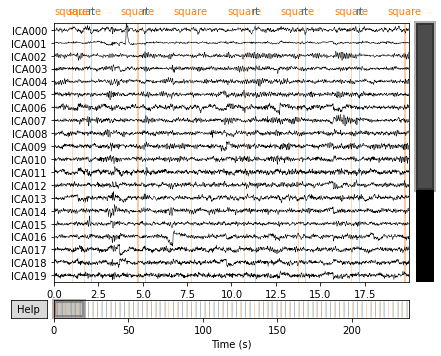

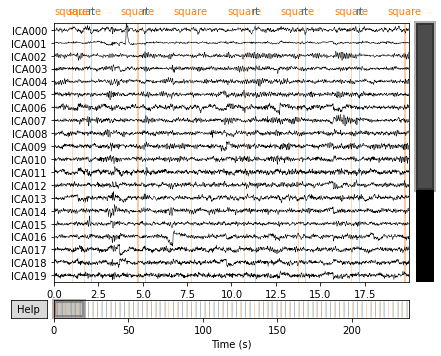

In [18]:
ica.plot_sources(raw_for_ica)

#### 绘制各成分地形图

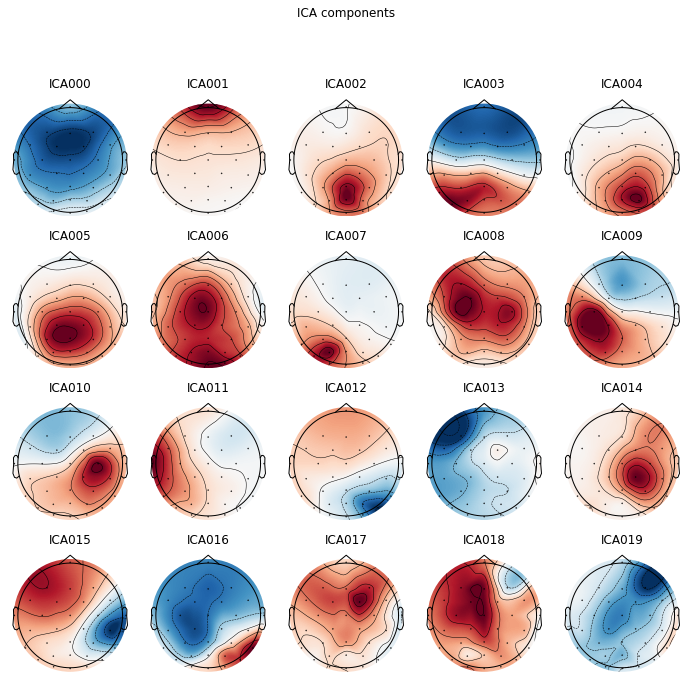

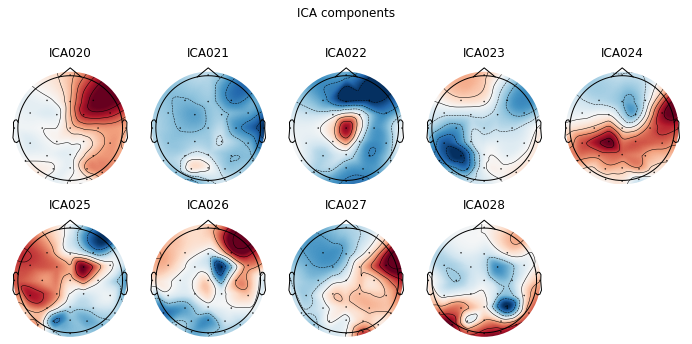

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x357.12 with 9 Axes>]

In [19]:
ica.plot_components()

#### 查看去掉某一成分前后信号差异

这里以去掉第2个成分（即ICA001）为例

Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


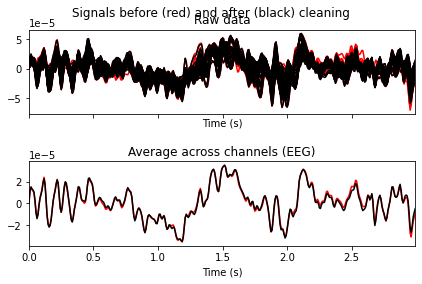

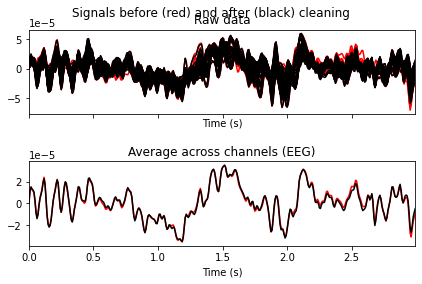

In [20]:
ica.plot_overlay(raw_for_ica, exclude=[1])

#### 单独可视化每个成分

这里可视化第2个成分（ICA001）和第17个成分（ICA016）

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


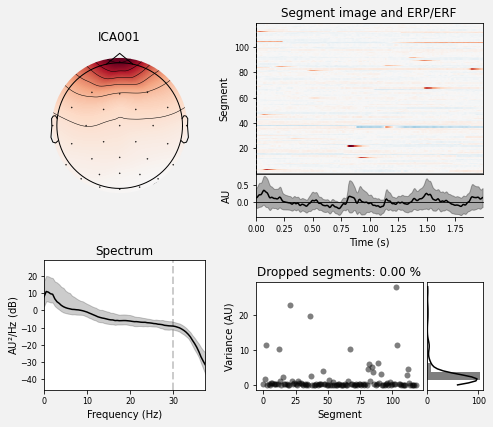

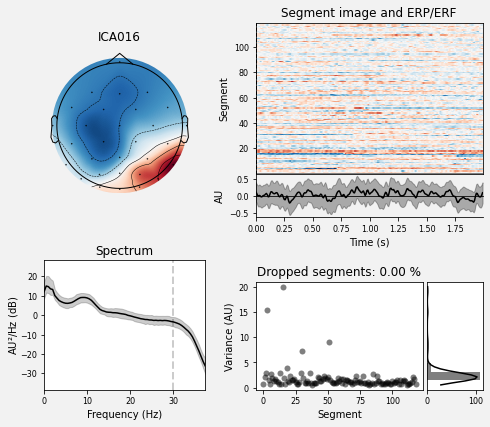

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [21]:
ica.plot_properties(raw, picks=[1, 16])

成分ICA001的能量较高处为前额，且在低频处能量较高，在一些trials中有明显增强  
可以判断为一个眼动成分  
成分ICA016不太像异常成分

#### 剔除成分

In [22]:
# 设定要剔除的成分序号
ica.exclude = [1]
# 应用到脑电数据上
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


<RawEEGLAB | eeglab_data.fdt, 32 x 30504 (238.3 s), ~7.5 MB, data loaded>

绘制ICA后的数据波形图

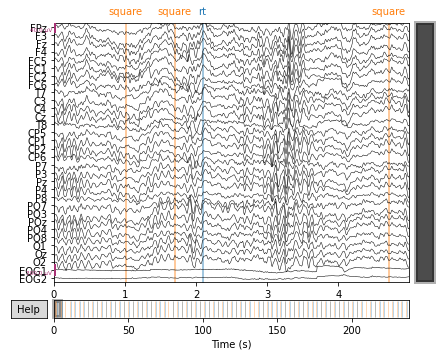

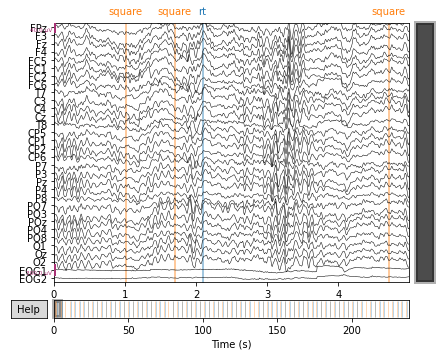

In [23]:
raw.plot(duration=5, n_channels=32, clipping=None)

# Step 4 重参考

由于此数据作者使用了乳突参考  
若数据需要进行参考，以'TP9'和'TP10'为参考电极为例，可以使用以下代码：  
> raw.set_eeg_reference(ref_channels=['TP9','TP10'])  

若使用平均参考，则使用以下代码：  
> raw.set_eeg_reference(ref_channels='average')  

若使用REST参考，则使用以下代码：  
> raw.set_eeg_reference(ref_channels='REST')

若使用双极参考，则使用以下代码：
(这里'EEG X'和'EEG Y'分别对应用于参考的阳极和阴极导联)
> raw_bip_ref = mne.set_bipolar_reference(raw, anode=['EEG X'], cathode=['EEG Y'])

# Step 5 分段

### 提取事件信息

首先，需要确定分段需要用到的markers  
查看数据中的markers

In [24]:
print(raw.annotations)

<Annotations | 154 segments: rt (74), square (80)>


即数据中包含两种markers，分别为'square'和'rt'

MNE有两种数据结构存储事件信息，分别为Events和Annotations

对于Annotations对象，其用字符串来表示时间类型，如上打印出来的所示  
其用时间点表示时间，且包含marker的持续时长，当然瞬时marker其持续时长为0  
其内部数据表示为一个类似List的类

In [25]:
# 基于Annotations打印数据的事件持续时长
print(raw.annotations.duration)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
# 基于Annotations打印数据的事件的描述信息
print(raw.annotations.description)

['square' 'square' 'rt' 'square' 'rt' 'square' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square'
 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square'
 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square'
 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'square' 'rt' 'sq

In [27]:
# 基于Annotations打印数据的事件的开始时间
print(raw.annotations.onset)

[  1.000068   1.695381   2.082407   4.703193   5.148224   7.711006
  10.718818  11.303858  13.726631  14.116658  16.734443  17.187474
  19.742256  20.199287  22.750068  23.136095  25.757881  26.124906
  28.765693  29.140719  31.773506  32.116529  34.781318  35.24635
  37.789131  38.254163  40.796943  41.229973  43.804756  44.30079
  46.812568  47.156592  49.820381  50.273412  52.828193  53.242222
  55.836006  56.211031  58.843818  59.237845  61.851631  62.183654
  64.859443  65.257471  67.867256  68.598306  70.875068  71.277096
  73.882881  74.323911  76.890693  79.898506  80.269531  82.906318
  83.312346  85.914131  86.313158  88.921943  89.280968  91.929756
  92.323783  94.937568  95.296593  97.945381  98.37141  100.953193
 101.363221 103.961006 104.332031 106.968818 107.343844 109.976631
 110.425662 112.984443 113.410472 115.992256 116.367281 119.000068
 119.359093 122.007881 122.409908 125.015693 125.441722 128.023506
 128.422533 131.031318 131.433346 134.039131 137.046943 137.4889

而Events对象，则是数据分段需要用到的一种事件记录数据类型  
其用一个整型'Event ID'编码事件类型，以样本的形式来表示时间  
且不含有marker的持续时长，其内部数据类型为NumPy Array

### 事件信息数据类型转换

将Annotations类型的事件信息转为Events类型

In [28]:
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['rt', 'square']


events为记录时间相关的矩阵，event_id为不同markers对应整型的字典信息  
这里打印出events矩阵的shape和event_id

In [29]:
print(events.shape, event_id)

(154, 3) {'rt': 1, 'square': 2}


即'rt' marker对应数字1，'square' marker对应数字2  
共154个markers

### 数据分段

基于Events对数据进行分段  
这里提取刺激前1秒到刺激后2秒的数据，即'square' marker对应-1s到2s的数据  
取baseline时间区间为刺激前0.5s到刺激出现  
并进行卡阈值，即在epoch中出现最大幅值与最小幅值的差大于2×10^-4则该epoch被剔除  
**注意**：这里的阈值设置较大，一般数据质量佳的情况下推荐设置为5×10^-5到1×10^4之间

In [30]:
epochs = mne.Epochs(raw, events, event_id=2, tmin=-1, tmax=2, baseline=(-0.5, 0), 
                    preload=True, reject=dict(eeg=2e-4))

Not setting metadata
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 80 events and 385 original time points ...
0 bad epochs dropped


即分段后的数据存为了Epochs类的对象epochs  
打印epochs即可看到分段后数据的相关信息

In [31]:
print(epochs)

<Epochs |  80 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~7.6 MB, data loaded,
 '2': 80>


### 分段数据可视化

可视化分段数据（这里显示4个epochs）

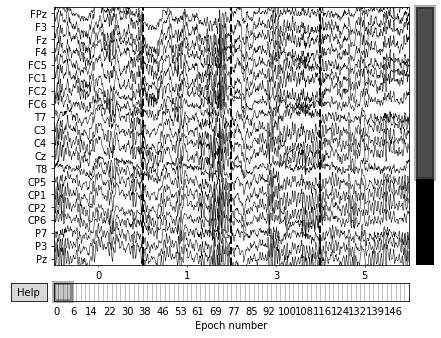

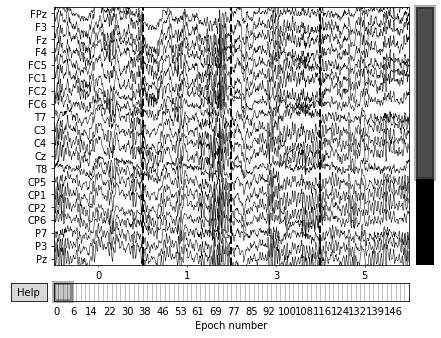

In [32]:
epochs.plot(n_epochs=4)

绘制功率谱图（逐导联）

    Using multitaper spectrum estimation with 7 DPSS windows


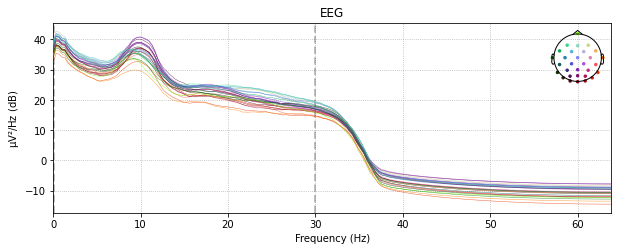

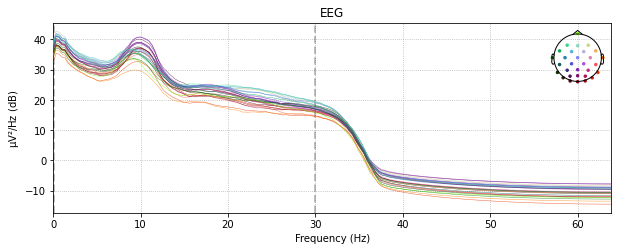

In [33]:
epochs.plot_psd(picks='eeg')

绘制功率谱拓扑图（分Theta、Alpha和Beta频段）

    Using multitaper spectrum estimation with 7 DPSS windows


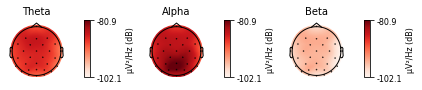

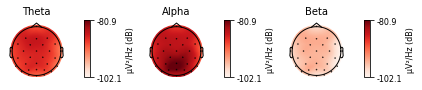

In [34]:
bands = [(4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta')]
epochs.plot_psd_topomap(bands=bands, vlim='joint')

# Step 6 叠加平均

MNE中使用Epochs类来存储分段数据，用Evoked类来存储叠加平均数据

### 数据叠加平均

In [35]:
evoked = epochs.average()

### 可视化叠加平均后的数据

#### 绘制逐导联的时序信号图

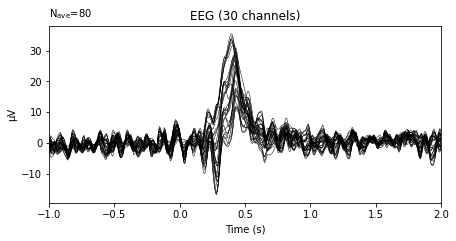

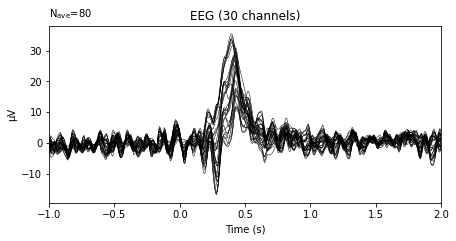

In [36]:
evoked.plot()

#### 绘制地形图

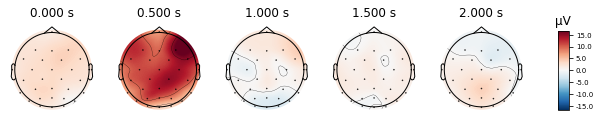

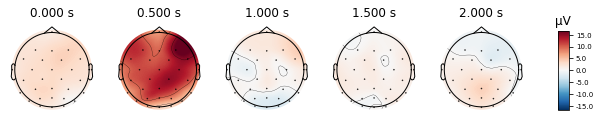

In [37]:
# 绘制0ms、0.5s、1s、1.5s和2s处的地形图
times = np.linspace(0, 2, 5)
evoked.plot_topomap(times=times, colorbar=True)

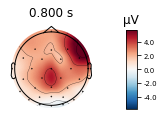

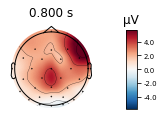

In [38]:
# 绘制某一特定时刻的地形图
# 此例绘制0.8s处，取0.75-0.85s的均值
evoked.plot_topomap(times=0.8, average=0.1)

#### 绘制联合图

No projector specified for this dataset. Please consider the method self.add_proj.


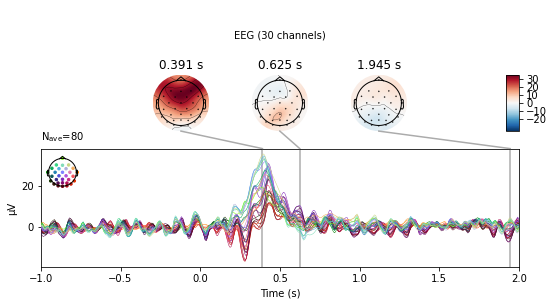

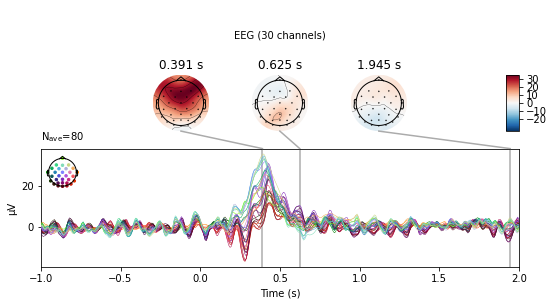

In [39]:
evoked.plot_joint()

#### 绘制逐导联热力图

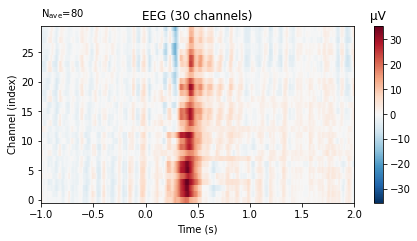

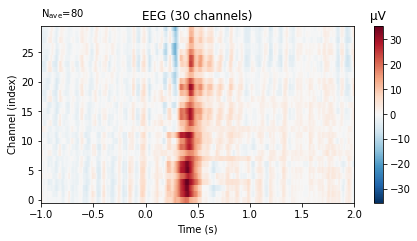

In [40]:
evoked.plot_image()

#### 绘制拓扑时序信号图

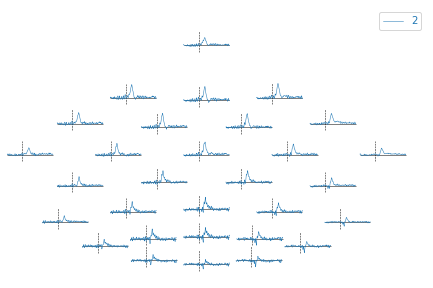

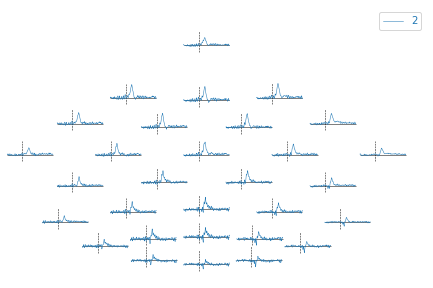

In [41]:
evoked.plot_topo()

#### 绘制平均所有电极后的ERP

combining channels using "mean"


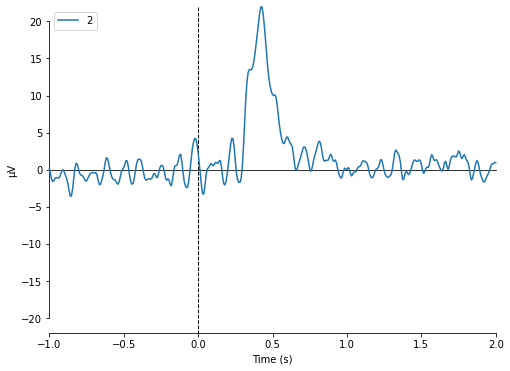

[<Figure size 576x432 with 1 Axes>]

In [42]:
mne.viz.plot_compare_evokeds(evokeds=evoked, combine='mean')

#### 绘制枕叶电极的平均ERP

combining channels using "mean"


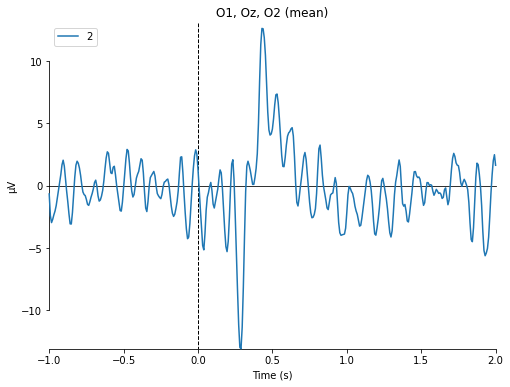

[<Figure size 576x432 with 1 Axes>]

In [43]:
mne.viz.plot_compare_evokeds(evokeds=evoked, picks=['O1', 'Oz', 'O2'], combine='mean')

# Step 7 时频分析

MNE提供了三种时频分析计算方法，分别是：
- Morlet wavelets，对应mne.time_frequency.tfr_morlet()  
- DPSS tapers，对应mne.time_frequency.tfr_multitaper()  
- Stockwell Transform，对应mne.time_frequency.tfr_stockwell()

这里，使用第一种方法为例

### 时频分析

计算能量（Power）与试次间耦合（inter-trial coherence，ITC）

In [44]:
# 设定一些时频分析的参数
# 频段选取4-30Hz
freqs = np.logspace(*np.log10([4, 30]), num=10)
n_cycles = freqs / 2.
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True)

返回的power即为能量结果，itc即为试次间耦合结果  
MNE中时频分析默认返回试次平均后的结果  
如果想获取每个试次单独的时频分析结果，将average参数设为False即可  
对应代码进行如下修改即可：
> power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False)

### 时频结果绘制

MNE的时频绘图方法里可以进行多种baseline矫正方法的选择  
其对应参数为mode，包括以下一些选择：  
- 'mean'，减去baseline均值  
- 'ratio'，除以baseline均值  
- 'logratio'，除以baseline均值并取log  
- 'percent'，减去baseline均值并除以baseline均值  
- 'zscore'，减去baseline均值再除以baseline标准差  
- 'zlogratio'，除以baseline均值并取log再除以baseline取log后的标准差  

下例中选择logratio的方法进行基线校正

#### 绘制结果

枕叶导联的power结果

Applying baseline correction (mode: logratio)


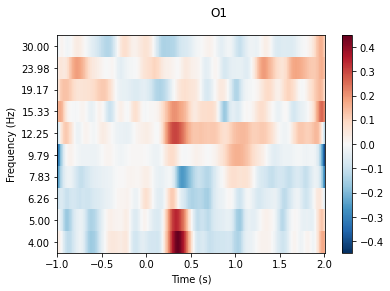

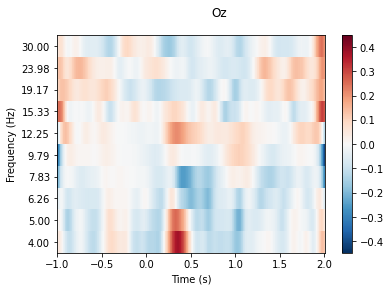

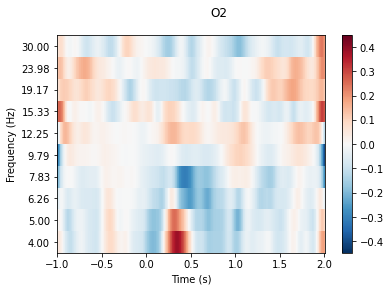

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [45]:
power.plot(picks=['O1', 'Oz', 'O2'], baseline=(-0.5, 0), mode='logratio', title='auto')

绘制枕叶导联的平均power结果

Applying baseline correction (mode: logratio)


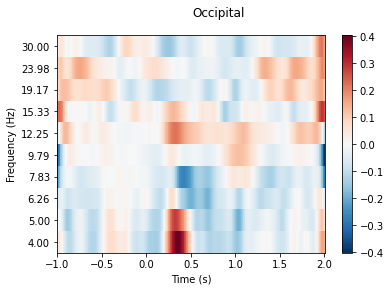

[<Figure size 432x288 with 2 Axes>]

In [46]:
power.plot(picks=['O1', 'Oz', 'O2'], baseline=(-0.5, 0), mode='logratio', title='Occipital', combine='mean')

绘制power拓扑图

Applying baseline correction (mode: logratio)


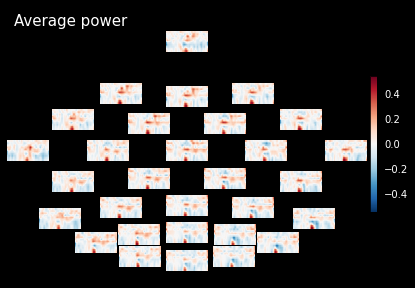

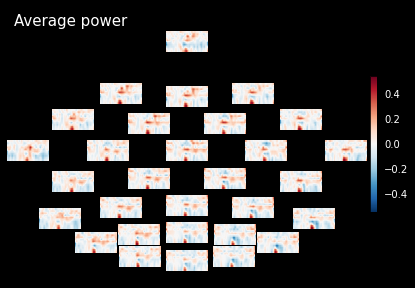

In [47]:
power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')

绘制不同频率的power拓扑图

Applying baseline correction (mode: logratio)


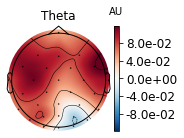

Applying baseline correction (mode: logratio)


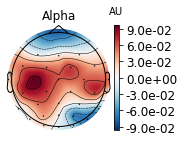

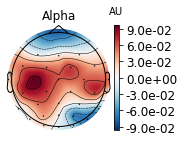

In [48]:
# 以theta power和alpha power为例
# 取0-0.5s的结果
power.plot_topomap(tmin=0, tmax=0.5, fmin=4, fmax=8, 
                   baseline=(-0.5, 0), mode='logratio', title='Theta')
power.plot_topomap(tmin=0, tmax=0.5, fmin=8, fmax=12, 
                   baseline=(-0.5, 0), mode='logratio', title='Alpha')

绘制联合图

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


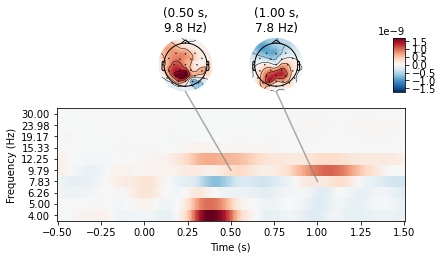

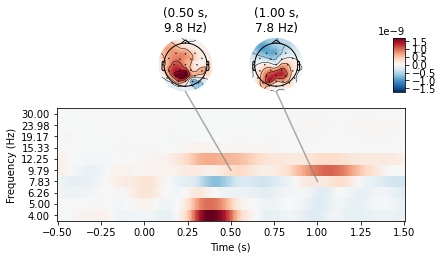

In [49]:
# 取-0.5s至1.5s的结果
# 并绘制0.5s时10Hz左右的结果和1s时8Hz左右的结果
power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-0.5, tmax=1.5,
                 timefreqs=[(0.5, 10), (1, 8)])

ITC结果绘制类似，以拓扑图为例

Applying baseline correction (mode: logratio)


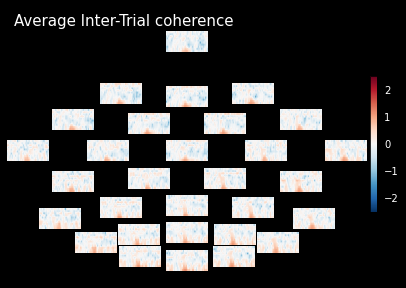

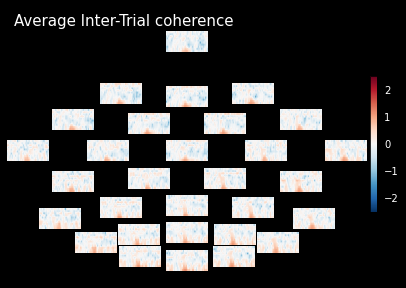

In [50]:
itc.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average Inter-Trial coherence')

# Step 8 提取数据

在进行相关计算后，往往希望能提取原始数据矩阵、分段数据矩阵、时频结果矩阵等等  
MNE中，Raw类（原始数据类型）、Epochs类（分段后数据类型）和Evocked类（叠加平均后数据类型）提供了get_data()方法  
AverageTFR类（时频分析后数据类型）提供了.data属性

### get_data()的使用

以epochs为例

In [51]:
epochs_array = epochs.get_data()

查看获取的数据

In [52]:
print(epochs_array.shape)
print(epochs_array)

(80, 32, 385)
[[[ 1.01172746e-05  2.43619995e-05  2.76869763e-05 ...  8.85848360e-06
    8.38757581e-06  4.99594619e-06]
  [ 1.90724252e-05  3.49982830e-05  1.52169891e-05 ... -6.16457047e-05
   -6.91169876e-05 -4.49072670e-05]
  [ 1.98350632e-05  3.51815698e-05  3.87066092e-05 ...  1.88477662e-05
    2.32565064e-05  2.44898711e-05]
  ...
  [-9.05551211e-07  8.06329195e-06  1.19545554e-05 ...  2.82222785e-05
    2.51862603e-05  2.70930922e-05]
  [-2.55151886e-06  7.25492306e-06  1.04012035e-05 ...  1.92780036e-05
    1.68515565e-05  2.34369827e-05]
  [ 1.27674268e-07  1.23689622e-05  1.50142111e-05 ...  1.05470042e-05
    9.50858372e-06  2.07743614e-05]]

 [[-2.85062192e-05 -2.46618341e-05 -2.54938147e-05 ... -6.34512553e-06
   -8.38142997e-06 -4.68180497e-06]
  [-1.98700747e-05 -2.32499213e-05 -2.34376177e-05 ... -5.87000498e-05
   -6.47002100e-05 -5.75247492e-05]
  [-4.77473531e-05 -4.29895652e-05 -4.65411811e-05 ... -1.74169339e-05
   -1.75768899e-05 -1.04244470e-05]
  ...
  [-1.606

即获取了NumPy Array形式的分段数据  
其shape为[80, 32, 385]  
分别对应80个试次，32个导联和385个时间点

若想获取eog外的导联数据，则可将上述代码改为：
> epochs_array = epochs.get_data(picks=['eeg'])

### .data的使用

In [53]:
power_array = power.data

查看获取的数据

In [54]:
print(power_array.shape)
print(power_array)

(30, 10, 385)
[[[8.80804754e-10 9.01941392e-10 9.13231242e-10 ... 1.23553039e-09
   1.24829104e-09 1.24009509e-09]
  [7.28838515e-10 7.59398746e-10 7.81324450e-10 ... 9.82473116e-10
   9.71015882e-10 9.44920791e-10]
  [6.80487712e-10 7.27325984e-10 7.67698102e-10 ... 9.40638893e-10
   8.93682032e-10 8.38510608e-10]
  ...
  [8.67688885e-11 9.22776556e-11 9.71476253e-11 ... 1.03299290e-10
   9.76272896e-11 9.13314356e-11]
  [5.77365339e-11 6.18878244e-11 6.56780826e-11 ... 6.72477571e-11
   6.35535680e-11 5.94868169e-11]
  [3.69467697e-11 3.87600279e-11 4.01462647e-11 ... 4.27532040e-11
   4.12267285e-11 3.92640215e-11]]

 [[2.07896240e-09 2.15070427e-09 2.19973188e-09 ... 3.22739646e-09
   3.26084601e-09 3.24348228e-09]
  [1.67273066e-09 1.76243426e-09 1.83440128e-09 ... 2.55004365e-09
   2.52378970e-09 2.46096159e-09]
  [1.49393535e-09 1.61185260e-09 1.71845179e-09 ... 2.29738201e-09
   2.19816300e-09 2.07654745e-09]
  ...
  [1.95555544e-10 2.07186589e-10 2.17232307e-10 ... 2.27559657e

即获取了NumPy Array形式的时频power结果  
其shape为[30, 10, 385]  
分别对应30个导联，10个频率和385个时间点

# 写在此篇最后

**虽然我们旨在写一个”傻瓜“而统一标准的教程**  
**但是我们依然不建议完全没有编程基础和脑电基础知识的人员盲目使用**  
**这里展示的只是一些步骤，其内容必要但未必深入**  
**因此，其中的内涵与奥妙、其中的技巧与思想**  
**需要读者在不断的体验中体会、积累经验**  
**愿此手册与我们、与读者共同进步！**

# 彩蛋

**你们的转发、分享与建议是我们继续进一步制作更深入文档的动力**  
**以及，欢迎关注公众号：路同学**

# 源码

见GitHub: [https://github.com/ZitongLu1996/Python-EEG-Handbook](https://github.com/ZitongLu1996/Python-EEG-Handbook)